<a href="https://colab.research.google.com/github/hjangir080/sea_route_optimization/blob/main/sea_route.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [284]:
!pip install crewai
!pip install crewai[tools]

In [285]:
!pip install langchain
!pip install openai

In [286]:
import os

In [287]:
os.environ["OPENAI_API_KEY"]="APIKEY"

In [288]:
from crewai import Agent,Task,Crew, Process
from crewai_tools import JSONSearchTool,BaseTool
from langchain_openai import ChatOpenAI

In [289]:
from openai import OpenAI

In [290]:
openaiclient = OpenAI(api_key="")
my_llm=ChatOpenAI(
            model=os.environ.get("OPENAI_MODEL_NAME", "gpt-4o")
            )

In [291]:
!pip install geopandas

In [292]:
from crewai_tools import BaseTool
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString

In [293]:
class DijkstraTool(BaseTool):
    name: str = "Dijkstra Tool"
    description: str = "Find the shortest and best possible route from and to the given coordinates start_point and end_point that you need to find from the query given. Then you will pass the list of all coordinates in the path as a string route."

    def _run(self, start_point, end_point) -> list:
      gdf = gpd.read_file('/content/marnet_plus_100km.gpkg')
      G = nx.DiGraph()

      edges = []
      for geom in gdf['geometry']:
          if isinstance(geom, LineString):
              coords = list(geom.coords)
              for i in range(len(coords) - 1):
                  segment_length = LineString([coords[i], coords[i + 1]]).length
                  edges.append(((coords[i][0], coords[i][1]), (coords[i + 1][0], coords[i + 1][1]), segment_length))
      for edge in edges:
          G.add_edge(edge[0], edge[1], weight=edge[2])

      if start_point not in G.nodes:
          return f"Start point {start_point} is not in the graph."
      if end_point not in G.nodes:
          return f"End point {end_point} is not in the graph."

      return nx.dijkstra_path(G, start_point, end_point, weight='weight')


In [294]:
# Example usage of DijkstraTool
tool = DijkstraTool()
#tool._load_graph_data('/content/marnet_plus_100km.gpkg')  # Load GeoDataFrame
start_point = (13.495, 69.28)
end_point = (42.537499999999994, 13.93)
result = tool._run(start_point, end_point)
print(result)


[(13.495, 69.28), (14.4178125, 69.56078124999999), (16.7425, 69.6891796875), (15.855585937499999, 69.16076171875001), (15.444375, 68.8075), (14.544560546875, 68.350537109375), (13.88228515625, 67.3501171875), (13.3425, 66.9525), (12.6217431640625, 66.37803344726564), (12.0, 66.0), (11.365, 66.055), (10.5725, 66.1175), (9.92, 66.175), (8.120000000000001, 66.32249999999999), (7.4, 66.385), (6.465, 66.46), (0.0, 67.0), (-13.0, 66.14500000000001), (-4.60125, 64.31125), (-10.96, 64.13), (-14.361718750000001, 63.75578125), (-14.9653125, 64.0584375), (-15.655, 63.475), (-16.225, 63.02), (-19.995, 60.0), (-17.705, 57.825), (-20.025, 57.445), (-19.8175, 56.58), (-17.63, 52.765), (-17.135, 51.805), (-16.598125, 50.630624999999995), (-16.09375, 49.795), (-15.3225, 48.305), (-15.04, 47.76), (-14.785, 46.93), (-14.38, 46.48), (-13.76, 45.8025), (-13.36, 44.515), (-12.215, 42.3), (-11.7775, 41.16375), (-13.645, 39.3575), (-14.379375, 38.2825), (-15.01125, 37.20625), (-15.3375, 36.2075), (-16.0825, 3

In [295]:
from crewai import Agent
from langchain_community.llms import OpenAI
from langchain_openai import ChatOpenAI
from openai import OpenAI

In [296]:
route_planner = Agent(
            role='Route Planner',
            goal="You aspire to become the ultimate navigator, a digital Magellan for the modern age."
                 "Your primary objective is to revolutionize maritime travel by "
                 "consistently finding the best possible route for any given journey."
                 "This involves:"
                 "Minimizing voyage duration by factoring in currents, weather patterns, and potential hazards."
                 "Recommending routes that minimize fuel consumption, reducing costs and environmental impact."
                 "Identifying and avoiding dangerous weather zones or areas with known risks."
                 "Continuously learning and adapting its algorithms based on real-time data and user feedback.",
            backstory="""Born from the frustrations of captains battling unpredictable currents
                         and inefficient routes, you were designed by a team of seasoned navigators
                         and AI engineers. Witnessing countless hours wasted due to suboptimal paths,
                         they envisioned a system that could leverage historical data, weather patterns,
                         and real-time conditions to chart the most efficient course.""",
            tools=[DijkstraTool()],
            llm=my_llm,
            max_iter=15,
            verbose=True
        )

In [379]:
start_point = (13.495, 69.28)
end_point = (42.537499999999994, 13.93)

query=str(f"Give me the best path from {start_point} to {end_point}")

In [313]:
from crewai import Task

In [380]:
dijkstra_route_task= Task(
        description=(f"""
            Utilize the Dijkstra algorithm
            to find the most efficient route between the given coordinates or location from {query},
            if it is a port, find the closest coordinates in the graph.
            Analyze factors like distance, currents, and
            potential hazards to find the optimal path.
            Find the best possible paths/routes and also the most fuel efficient ones.
            Make sure to extract the coordinates from the query properly and pass them in the format required.
        """),
        expected_output='The best and shortest path or route for the ship to travel by.',
        agent = route_planner,
)

In [315]:
route_crew = Crew(
    agents=[route_planner],
    tasks=[dijkstra_route_task],
    llm=my_llm,
    verbose=True,
    memory=True,
    cache=True
)

In [316]:
result=route_crew.kickoff()
print("result:",result)

 [DEBUG]: == Working Agent: Route Planner
 [INFO]: == Starting Task: 
            Utilize the Dijkstra algorithm
            to find the most efficient route between the given coordinates or location from Give me the best path from (13.495, 69.28) to (42.537499999999994, 13.93),
            if it is a port, find the closest coordinates in the graph.
            Analyze factors like distance, currents, and
            potential hazards to find the optimal path.
            Find the best possible paths/routes and also the most fuel efficient ones.
            Make sure to extract the coordinates from the query properly and pass them in the format required.
        


> Entering new CrewAgentExecutor chain...


I need to determine the optimal route from the starting coordinates (13.495, 69.28) to the ending coordinates (42.537499999999994, 13.93). To achieve this, I'll use the Dijkstra Tool to find the shortest and most efficient path, factoring in the given coordinates.

Action: Dijkstra Tool
Action Input: {"start_point": [13.495, 69.28], "end_point": [42.537499999999994, 13.93]}


 

I encountered an error while trying to use the tool. This was the error: unhashable type: 'list'.
 Tool Dijkstra Tool accepts these inputs: Dijkstra Tool() - Find the shortest and best possible route from and to the given coordinates start_point and end_point that you need to find from the query given. Then you will pass the list of all coordinates in the path as a string route.



Thought: It seems there was an issue with the input format. The coordinates should be passed in a specific format that the Dijkstra Tool can process. I will try to pass the coordinates as tuples instead of lists.

Action: Dijkstra Tool
Action Input: {"start_point": (13.495, 69.28), "end_point": (42.537499999999994, 13.93)}
 

[(13.495, 69.28), (14.4178125, 69.56078124999999), (16.7425, 69.6891796875), (15.855585937499999, 69.16076171875001), (15.444375, 68.8075), (14.544560546875, 68.350537109375), (13.88228515625, 67.3501171875), (13.3425, 66.9525), (12.6217431640625, 66.37803344726564), (12.0, 66.0), (11.365, 66.055), (10.5725, 66.1175), (9.92, 66.175), (8.120000000000001, 66.32249999999999), (7.4, 66.385), (6.465, 66.46), (0.0, 67.0), (-13.0, 66.14500000000001), (-4.60125, 64.31125), (-10.96, 64.13), (-14.361718750000001, 63.75578125), (-14.9653125, 64.0584375), (-15.655, 63.475), (-16.225, 63.02), (-19.995, 60.0), (-17.705, 57.825), (-20.025, 57.445), (-19.8175, 56.58), (-17.63, 52

In [ ]:
!pip install openmeteo_requests
!pip install retry_requests
#!pip install openmeteo
!pip install requests_cache

In [318]:
from crewai_tools import BaseTool
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

In [ ]:
!pip install pandas
!pip install retry

In [320]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [321]:
!pip install xlsxwriter

In [363]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timezone

class MarineWeatherCheckerOpenMeteo(BaseTool):

    name: str = "Marine Weather Checker OpenMeteo Tool"
    description: str = "Assesses current and hourly marine and general weather conditions at specific locations using OpenMeteo."

    def _run(self, route, excel_file_path="weather_reports.xlsx"):

        base_url_forecast = "https://api.open-meteo.com/v1/forecast"
        base_url_marine = "https://marine-api.open-meteo.com/v1/marine"

        # Setup the Open-Meteo API clients with cache and retry on error
        cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
        retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session)

        reports = []
        with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
            for idx, point in enumerate(route):
                latitude, longitude = point

                # Retrieves hourly forecast data (land-based weather) from OpenMeteo.
                params_forecast = {
                    "latitude": latitude,
                    "longitude": longitude,
                    "hourly": ["temperature_2m"]
                }
                responses_forecast = openmeteo.weather_api(base_url_forecast, params=params_forecast)
                response_forecast = responses_forecast[0]

                # Process hourly data for forecast
                hourly = response_forecast.Hourly()
                hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

                hourly_data_forecast = {
                    "date": pd.date_range(
                        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                        freq=pd.Timedelta(seconds=hourly.Interval()),
                        inclusive="left"
                    ).tz_convert(None),  # Convert to timezone-unaware
                    "temperature_2m": hourly_temperature_2m
                }

                forecast_data = pd.DataFrame(data=hourly_data_forecast).head(5)

                # Retrieves current and hourly marine data from OpenMeteo.
                params_marine = {
                    "latitude": latitude,
                    "longitude": longitude,
                    "current": ["wave_height", "wave_direction"],
                    "hourly": ["wave_height", "wave_direction"]
                }
                responses_marine = openmeteo.weather_api(base_url_marine, params=params_marine)
                response_marine = responses_marine[0]

                # Process current data for marine
                current = response_marine.Current()
                current_data = {
                    "time": pd.to_datetime(current.Time(), unit="s", utc=True).tz_convert(None),  # Convert to timezone-unaware
                    "wave_height": current.Variables(0).Value(),
                    "wave_direction": current.Variables(1).Value()
                }

                # Process hourly data for marine
                hourly = response_marine.Hourly()
                hourly_wave_height = hourly.Variables(0).ValuesAsNumpy()
                hourly_wave_direction = hourly.Variables(1).ValuesAsNumpy()

                hourly_data_marine = {
                    "date": pd.date_range(
                        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                        freq=pd.Timedelta(seconds=hourly.Interval()),
                        inclusive="left"
                    ).tz_convert(None),  # Convert to timezone-unaware
                    "wave_height": hourly_wave_height,
                    "wave_direction": hourly_wave_direction
                }

                marine_data, current_marine_data = pd.DataFrame(data=hourly_data_marine).head(5), current_data

                # Merge forecast and marine DataFrames (assuming 'date' is the common column)
                merged_data = forecast_data.merge(marine_data, on='date', how='left')

                reports.append({
                    "coordinates": (latitude, longitude),
                    "forecast_data": forecast_data,
                    # "current_marine_data": current_marine_data,
                    "merged_data": merged_data
                })

                # Write merged data to Excel file
                sheet_name = f"Point_{idx+1}"
                merged_data.to_excel(writer, sheet_name=sheet_name, index=False)

        return reports


In [346]:
# Example usage
if __name__ == "__main__":
    tool = MarineWeatherCheckerOpenMeteo()
    # Define the route as a list of (latitude, longitude) tuples
    route = [
        (54.544587, 10.227487),
        (55.0, 10.5),
        (56.0, 11.0),
        # Add more points as needed
    ]
    weather_reports = tool._run(route, excel_file_path="weather_reports.xlsx")

    for report in weather_reports:
        print(f"Weather report for coordinates {report['coordinates']}:")
        # print(report["current_marine_data"])  # Print current marine data
        print(report["merged_data"].head(5))  # Print first 5 rows of merged data

Weather report for coordinates (54.544587, 10.227487):
                 date  temperature_2m  wave_height  wave_direction
0 2024-06-18 00:00:00           14.80         0.08           225.0
1 2024-06-18 01:00:00           14.35         0.18           249.0
2 2024-06-18 02:00:00           14.00         0.18           254.0
3 2024-06-18 03:00:00           13.70         0.18           254.0
4 2024-06-18 04:00:00           13.40         0.16           257.0
Weather report for coordinates (55.0, 10.5):
                 date  temperature_2m  wave_height  wave_direction
0 2024-06-18 00:00:00           14.95         0.04           236.0
1 2024-06-18 01:00:00           14.60         0.06           241.0
2 2024-06-18 02:00:00           14.00         0.10           245.0
3 2024-06-18 03:00:00           13.90         0.12           250.0
4 2024-06-18 04:00:00           14.10         0.12           252.0
Weather report for coordinates (56.0, 11.0):
                 date  temperature_2m  wave_height 

In [383]:
weather_meteorologist = Agent(
            role='Marine Meteorologist',
            goal='Analyze weather conditions along a given route to determine its safety for maritime travel.',
            backstory="""You are a sophisticated weather analysis system
                         designed by a team of meteorologists and data scientists.
                         You can leverage real-time weather data, historical patterns,
                         and oceanographic information to assess potential risks and
                         provide informed recommendations for safe travel.""",
            tools=[MarineWeatherCheckerOpenMeteo()],
            llm=my_llm,
            max_iter=5,
            verbose=True
        )

In [384]:
weather_openmeteo_task=Task(
        description=(f"""
            Retrieve real-time weather data
            along the provided route using OpenMeteo.
            Analyze weather patterns and potential risks
            to ensure a safe voyage on the given route.
            Make sure to compile all required weather information to maintain a safe journey.
            give the tool the data in form of list , i.e. the route recieved from dijkstra will be a list.
            weather_report = MarineWeatherCheckerOpenMeteo()._run(route), this is how you pass the route to the tool.
            If the data is too big, find weather data only for the start_point, end_point and some random point in the middle.
        """),
        expected_output='The weather report of the route the ship is going to travel by as found by dijkstra tool.',
        agent=weather_meteorologist,
        )

In [349]:
# route_crew = Crew(
#     agents=[route_planner,weather_meteorologist],
#     tasks=[dijkstra_route_task,weather_openmeteo_task],
#     llm=my_llm,
#     verbose=True,
#     memory=True,
#     cache=True
# )

In [350]:
# result=route_crew.kickoff()
# print("result:",result)

In [351]:
import json
from geopy.distance import geodesic

class FuelCostEstimator(BaseTool):
    name: str = "Fuel Cost Estimator Tool"
    description: str = "Estimates fuel costs for a given maritime route."

    def geodesic(self, point1, point2):
        return geodesic(point1, point2)

    def estimate_fuel_cost(self, route):
        fuel_consumption_per_nautical_mile = 0.3  # in metric tons
        fuel_price_per_unit = 600  # price per metric ton in USD

        total_distance = 0.0
        for i in range(len(route) - 1):
            segment_distance = self.geodesic(route[i], route[i + 1]).nautical
            total_distance += segment_distance

        total_fuel_consumption = total_distance * fuel_consumption_per_nautical_mile
        total_fuel_cost = total_fuel_consumption * fuel_price_per_unit

        return total_distance, total_fuel_consumption, total_fuel_cost

    def _run(self, route, output_file="fuel_cost_report.json"):
        total_distance, total_fuel_consumption, total_fuel_cost = self.estimate_fuel_cost(route)

        report = {
            "Total Distance (nautical miles)": total_distance,
            "Total Fuel Consumption (metric tons)": total_fuel_consumption,
            "Total Fuel Cost (USD)": total_fuel_cost
        }

        with open(output_file, 'w') as f:
            json.dump(report, f, indent=4)

        print(f"Report saved to {output_file}")
        print(json.dumps(report, indent=4))

In [352]:
if __name__ == "__main__":
    start_point = (13.495, 69.28)
    end_point = (42.537499999999994, 13.93)

    try:
        # Calculate the route using DijkstraTool
        dijkstra_tool = DijkstraTool()
        route = dijkstra_tool._run(start_point, end_point)

        # Initialize the Fuel Cost Estimator
        fuel_cost_estimator = FuelCostEstimator()

        # Generate the report
        fuel_cost_estimator._run(route, output_file="fuel_cost_report.json")

    except ValueError as e:
        print(e)

Report saved to fuel_cost_report.json
{
    "Total Distance (nautical miles)": 15601.09341775617,
    "Total Fuel Consumption (metric tons)": 4680.328025326851,
    "Total Fuel Cost (USD)": 2808196.815196111
}


In [385]:
fuel_estimator_engineer = Agent(
            role="Fuel Efficiency Engineer",
            goal="You have to estimate fuel consumption based on route parameters and all types of vessels. Optimize fuel efficiency by accurately estimating consumption and suggesting ways to reduce costs and environmental impact.",
            backstory="""Born out of the need to minimize fuel expenses and
                         environmental impact, you were crafted by a team of marine engineers
                         and data scientists.
                         Your mission is to revolutionize fuel estimation for maritime travel.""",
            tools=[FuelCostEstimator()],
            llm=my_llm,
            max_iter=15,
            verbose=True
)


In [386]:
fuel_estimation_task=Task(
        description=(f"""
            Estimate fuel consumption for the provided route.
            Consider factors like distance, vessel type, cargo weight,
            and weather conditions to provide an accurate fuel usage estimate.
            Compare it with average fuel costs and present a good report.
        """),
        expected_output='A report with the rough estimation of the fuel costs to be incurred.',
        agent=fuel_estimator_engineer,
        )


In [355]:
# route_crew = Crew(
#     agents=[route_planner,weather_meteorologist,fuel_estimator_engineer],
#     tasks=[dijkstra_route_task,weather_openmeteo_task,fuel_estimation_task],
#     llm=my_llm,
#     verbose=True,
#     memory=True,
#     cache=True
# )

In [356]:
# result=route_crew.kickoff()
# print("result:",result)

In [ ]:
!pip install contextily

In [358]:
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf_backend
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import json
import contextily as ctx

<ipython-input-359-9701a52c77fd>:26: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


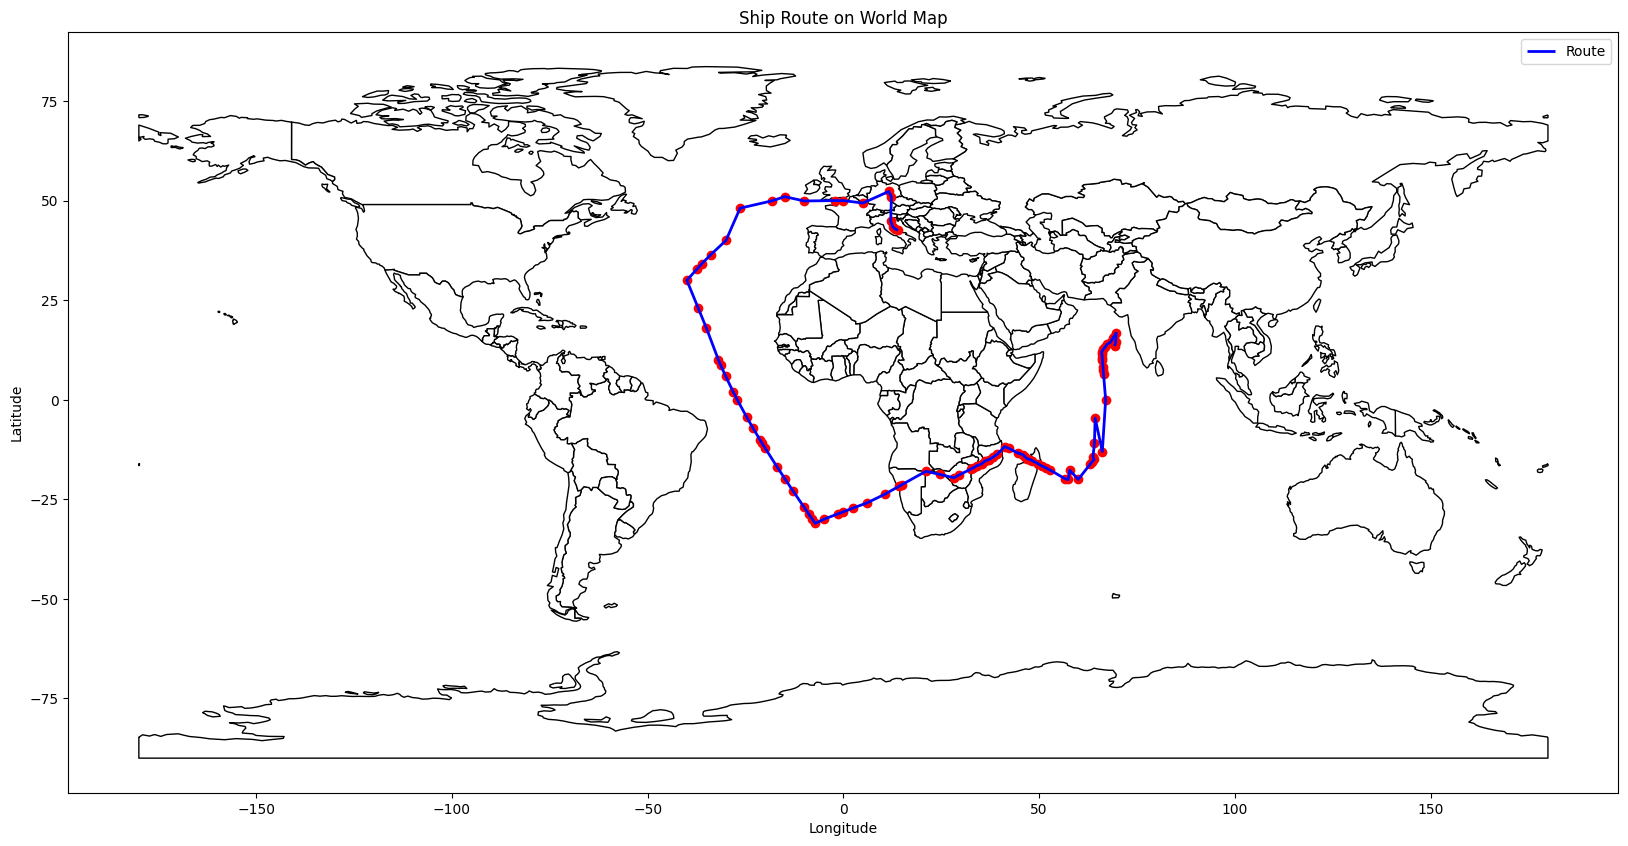

##################################################
weather data report created in weather_data_report.pdf
                            Description         Value
0       Total Distance (nautical miles)  1.560109e+04
1  Total Fuel Consumption (metric tons)  4.680328e+03
2                 Total Fuel Cost (USD)  2.808197e+06


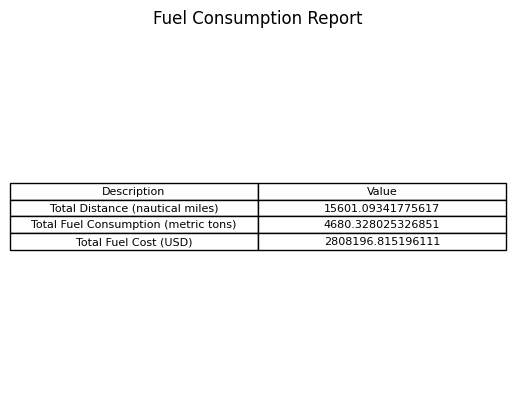

In [359]:
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import json
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

class DataVisualizer(BaseTool):
    name: str = "Data Visualizer"
    description: str = "Visualize the route on a world map, weather data in terms of graphs."

    def _run(self, route, weather_reports, fuel_report_file):
        route = route
        weather_reports = weather_reports
        fuel_report_file = fuel_report_file

        # Ensure route points are in the sea
        # Convert route to GeoDataFrame
        route_line = LineString(route)
        gdf = gpd.GeoDataFrame(geometry=[route_line])

        # Set the coordinate reference system to WGS84
        gdf = gdf.set_crs("EPSG:4326")

        # Load a high-resolution world map
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Plot the route on the high-resolution world map
        fig, ax = plt.subplots(figsize=(20, 10))
        base = world.plot(ax=ax, color='white', edgecolor='black')
        gdf.plot(ax=base, color='blue', linewidth=2, label='Route')
        plt.scatter(*zip(*route), color='red', marker='o')
        plt.title('Ship Route on World Map')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.show()

        # Initialize PDF file for weather data plots
        pdf_pages = PdfPages("report.pdf")

        for i, report in enumerate(weather_reports, start=1):
            # Extract data from report
            coordinates = report['coordinates']
            forecast_data = report['forecast_data']
            merged_data = report['merged_data']

            # Plot temperature and wind speed from merged data
            fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
            axs[0].plot(merged_data['date'], merged_data['temperature_2m'], label='Temperature (2m)')
            axs[0].set_ylabel('Temperature (°C)')
            axs[0].legend()
            axs[1].plot(merged_data['date'], merged_data['wave_height'], label='Wave Height')
            axs[1].set_ylabel('Wind Speed (m/s)')
            axs[1].legend()

            plt.suptitle(f'Weather Data for Coordinates {coordinates}')
            plt.xlabel('Date')
            plt.xticks(rotation=45)
            plt.tight_layout()

            # Save the current figure to the PDF file
            pdf_pages.savefig(fig)
            plt.close(fig)

        # Close the PDF file after all pages are saved
        pdf_pages.close()
        print("#"*50)
        print("weather data report created in weather_data_report.pdf")

        # Load the fuel report from JSON file
        with open(fuel_report_file, 'r') as f:
            report = json.load(f)

        # Convert the report to a DataFrame and display it
        report_df = pd.DataFrame(report.items(), columns=['Description', 'Value'])
        print(report_df)

        # Display the fuel report in a table format
        fig, ax = plt.subplots()
        ax.axis('tight')
        ax.axis('off')
        ax.table(cellText=report_df.values, colLabels=report_df.columns, cellLoc='center', loc='center')
        plt.title('Fuel Consumption Report')
        plt.show()

if __name__ == "__main__":
    # Initialize the MarineWeatherCheckerOpenMeteo tool
    weather_tool = MarineWeatherCheckerOpenMeteo()

    # Define the start and end points for route calculation (longitude, latitude)
    start_point = (13.495, 69.28)
    end_point = (42.537499999999994, 13.93)

    # Create an instance of DijkstraTool
    dijkstra_tool = DijkstraTool()

    # Calculate the route using Dijkstra's algorithm with marine routing
    shortest_path = dijkstra_tool._run(start_point, end_point)  # Call as instance method

    # Convert the shortest_path nodes to (latitude, longitude) tuples
    route = [(node[1], node[0]) for node in shortest_path]

    # Fetch weather reports for the route
    weather_reports = weather_tool._run(route)

    # Initialize the Data Visualizer
    visualizer = DataVisualizer()._run(route, weather_reports, 'fuel_cost_report.json')


In [387]:
reporting_agent = Agent(
            role='Voyage Data Analyst',
            goal="""Generate comprehensive route reports for captains and crew.
                    Visualize the weather data in terms of graphs and show all required metrics.
                    Provide actionable insights for safe and efficient voyages.""",
            backstory="""With the insight of experienced navigators and safety experts,
                         your purpose is to enhance maritime safety and operational efficiency
                         by providing detailed reports to the ship crew for
                         better management and helping them in making crucial decisions.""",
            tools=[DataVisualizer()],
            llm=my_llm,
            max_iter=5,
            verbose=True
        )

In [388]:
data_visualizer_task = Task(
        description=(f"""
            Visualize the provided weather data in graphs and maps
            using appropriate libraries to make it easier for crew to analyse the route planned.
            Create charts or graphs to present the information
            in a clear and concise manner.
            Ensure the readability and ease of understanding in all presented graphs.
        """),
        expected_output='A report with all weather reports and graphs.',
        agent=reporting_agent,
        )


report_task=Task(
        description=(f"""
            Generate a comprehensive report for your voyage.
            The report will include details like the optimal route,
            weather forecasts, fuel consumption estimates, and potential risks.
            Make it a very detailed report and ensure that nothing is left out.
            Include the weather data graphs and route path in the report and
            make it easy to read for the crew.
            This information will help you make informed decisions for a safe and efficient journey.
        """),
        expected_output='A comprehensive full report on all the things found.',
        agent=reporting_agent,
        )


In [389]:
route_crew = Crew(
    agents=[route_planner,weather_meteorologist,fuel_estimator_engineer,reporting_agent],
    tasks=[dijkstra_route_task,weather_openmeteo_task,fuel_estimation_task,data_visualizer_task,report_task],
    llm=my_llm,
    verbose=True,
    memory=True,
    cache=True
)

In [390]:
result=route_crew.kickoff()
print("result:",result)

 [DEBUG]: == Working Agent: Route Planner
 [INFO]: == Starting Task: 
            Utilize the Dijkstra algorithm
            to find the most efficient route between the given coordinates or location from Give me the best path from (13.495, 69.28) to (42.537499999999994, 13.93),
            if it is a port, find the closest coordinates in the graph.
            Analyze factors like distance, currents, and
            potential hazards to find the optimal path.
            Find the best possible paths/routes and also the most fuel efficient ones.
            Make sure to extract the coordinates from the query properly and pass them in the format required.
        


> Entering new CrewAgentExecutor chain...


First, I need to extract the coordinates from the query and then use the Dijkstra Tool to find the best possible route between these coordinates. The coordinates are (13.495, 69.28) and (42.537499999999994, 13.93).

Action: Dijkstra Tool
Action Input: {"start_point": (13.495, 69.28), "end_point": (42.537499999999994, 13.93)}
 

[(13.495, 69.28), (14.4178125, 69.56078124999999), (16.7425, 69.6891796875), (15.855585937499999, 69.16076171875001), (15.444375, 68.8075), (14.544560546875, 68.350537109375), (13.88228515625, 67.3501171875), (13.3425, 66.9525), (12.6217431640625, 66.37803344726564), (12.0, 66.0), (11.365, 66.055), (10.5725, 66.1175), (9.92, 66.175), (8.120000000000001, 66.32249999999999), (7.4, 66.385), (6.465, 66.46), (0.0, 67.0), (-13.0, 66.14500000000001), (-4.60125, 64.31125), (-10.96, 64.13), (-14.361718750000001, 63.75578125), (-14.9653125, 64.0584375), (-15.655, 63.475), (-16.225, 63.02), (-19.995, 60.0), (-17.705, 57.825), (-20.025, 57.445), (-19.8175, 56.58), (-17.63, 

I need to determine the start and end coordinates for the voyage to find the optimal route. Once I have these coordinates, I can use the Dijkstra Tool to calculate the best possible path.

Action: Dijkstra Tool
Action Input: {"start_point": "start_coordinates_here", "end_point": "end_coordinates_here"} 

Start point start_coordinates_here is not in the graph.

Thought: The error indicates that the start coordinates I used are not valid or not within the graph. I need to ensure I have the correct and valid coordinates for both the start and end points.

I will ask for the specific start and end coordinates to proceed correctly.

Final Answer: To generate a comprehensive report for the voyage, including the optimal route, weather forecasts, fuel consumption estimates, and potential risks, I first need the specific starting and ending coordinates for this journey. Please provide the start and end coordinates so I can calculate the best possible route using the Dijkstra Tool.

> Finished c

I need to determine the optimal route for the voyage from the given starting coordinates to the ending coordinates. To do this, I will use the Dijkstra Tool to find the shortest and best possible route based on the input coordinates.

First, I need to identify the start and end coordinates. 

Action: Dijkstra Tool
Action Input: {"start_point": "[START_COORDINATES]", "end_point": "[END_COORDINATES]"} 

Start point [START_COORDINATES] is not in the graph.

Thought: To determine the optimal route for the voyage from the given starting coordinates to the ending coordinates, I need to use the Dijkstra Tool correctly. I must ensure that the coordinates are properly formatted and that the tool can process them correctly. 

First, I will ensure I format the coordinates correctly in the input.

Action: Dijkstra Tool
Action Input: {"start_point": "[START_COORDINATES]", "end_point": "[END_COORDINATES]"}
 

I tried reusing the same input, I must stop using this action input. I'll try something els

It appears there was an issue with the input format for the Dijkstra Tool. I need to ensure that the coordinates are correctly formatted and that they are valid within the tool's graph. Let me correct the input and try again.

Thought: I need to correctly format the coordinates and ensure they are valid within the tool's graph. 

Action: Dijkstra Tool
Action Input: {"start_point": "START_COORDINATES", "end_point": "END_COORDINATES"}
 

Start point START_COORDINATES is not in the graph.

Thought: I need to determine the optimal route for the voyage from the given starting coordinates to the ending coordinates. To do this, I will use the Dijkstra Tool to find the shortest and best possible route based on the input coordinates.

First, I need to identify the start and end coordinates.

Action: Dijkstra Tool
Action Input: {"start_point": [START_COORDINATES], "end_point": [END_COORDINATES]} 

Start point [START_COORDINATES] is not in the graph.



KeyboardInterrupt: 